In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

**Step 1 — Load & Prepare Dataset**

In [14]:
# 1. Load dataset
df = pd.read_csv('/content/breast-cancer.csv')  # Replace with your file name
df.head()
# 2. Drop unnecessary columns
df = df.drop(columns=["id"])

# 3. Encode target (M=1, B=0)
label_encoder = LabelEncoder()
df["diagnosis"] = label_encoder.fit_transform(df["diagnosis"])

# 4. Separate features (X) and target (y)
X = df.drop(columns=["diagnosis"])
y = df["diagnosis"]

# 5. Scale features (SVM needs scaling)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 6. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Unique labels:", y.unique())


Train shape: (398, 30)
Test shape: (171, 30)
Unique labels: [1 0]


**Step 2 — Train SVM with Linear & RBF Kernel**

In [15]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# ----- Linear Kernel -----
svm_linear = SVC(kernel='linear', C=1, random_state=42)
svm_linear.fit(X_train, y_train)

# ----- RBF Kernel -----
svm_rbf = SVC(kernel='rbf', C=1, gamma='scale', random_state=42)
svm_rbf.fit(X_train, y_train)

# ----- Predictions -----
y_pred_linear = svm_linear.predict(X_test)
y_pred_rbf = svm_rbf.predict(X_test)

# ----- Accuracy -----
print("Linear Kernel Accuracy:", accuracy_score(y_test, y_pred_linear))
print("RBF Kernel Accuracy:", accuracy_score(y_test, y_pred_rbf))

# ----- Detailed Classification Report -----
print("\nLinear Kernel Report:\n", classification_report(y_test, y_pred_linear))
print("\nRBF Kernel Report:\n", classification_report(y_test, y_pred_rbf))



Linear Kernel Accuracy: 0.9649122807017544
RBF Kernel Accuracy: 0.9649122807017544

Linear Kernel Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97       107
           1       1.00      0.91      0.95        64

    accuracy                           0.96       171
   macro avg       0.97      0.95      0.96       171
weighted avg       0.97      0.96      0.96       171


RBF Kernel Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97       107
           1       1.00      0.91      0.95        64

    accuracy                           0.96       171
   macro avg       0.97      0.95      0.96       171
weighted avg       0.97      0.96      0.96       171



**Step 3 — Visualize Decision Boundary (PCA to 2D)))**

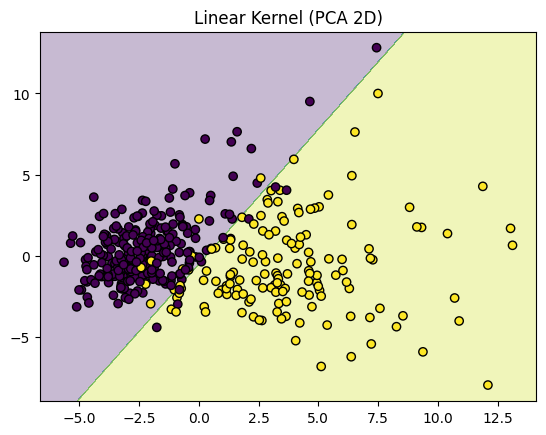

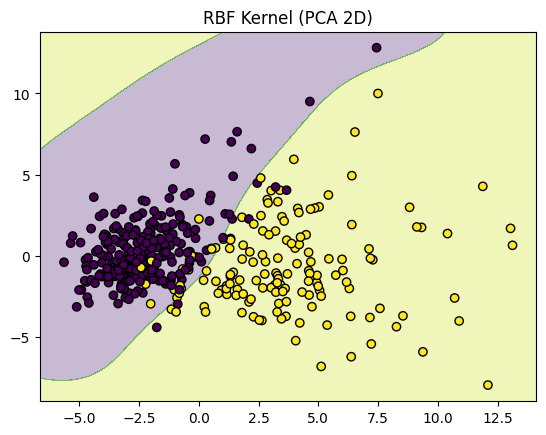

In [19]:
 import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import SVC

# 1️⃣ Reduce to 2 dimensions for visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# 2️⃣ Train SVM on reduced data (Linear & RBF)
svm_linear_2d = SVC(kernel='linear', C=1, random_state=42)
svm_linear_2d.fit(X_train_pca, y_train)

svm_rbf_2d = SVC(kernel='rbf', C=1, gamma='scale', random_state=42)  # ✅ Fixed parenthesis
svm_rbf_2d.fit(X_train_pca, y_train)

# 3️⃣ Function to plot decision boundaries
def plot_decision_boundary(model, X, y, title):
    h = 0.02  # step size in mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o')
    plt.title(title)
    plt.show()

# 4️⃣ Plot for Linear Kernel
plot_decision_boundary(svm_linear_2d, X_train_pca, y_train, "Linear Kernel (PCA 2D)")

# 5️⃣ Plot for RBF Kernel
plot_decision_boundary(svm_rbf_2d, X_train_pca, y_train, "RBF Kernel (PCA 2D)")


**Step 4 — Hyperparameter Tuning (C & gamma)**

In [20]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],       # Regularization strength
    'gamma': [0.001, 0.01, 0.1, 1, 'scale', 'auto'],  # Kernel coefficient
    'kernel': ['rbf']             # RBF kernel for non-linear decision boundaries
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=SVC(),
    param_grid=param_grid,
    cv=5,                # 5-fold cross-validation
    scoring='accuracy',
    n_jobs=-1            # use all CPU cores
)

# Fit on full training set
grid_search.fit(X_train, y_train)

# Best parameters & score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-validation Accuracy:", grid_search.best_score_)

# Train final model with best parameters
best_svm_rbf = grid_search.best_estimator_
best_svm_rbf.fit(X_train, y_train)

# Evaluate on test set
test_accuracy = best_svm_rbf.score(X_test, y_test)
print("Test Set Accuracy:", test_accuracy)


Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best Cross-validation Accuracy: 0.9722151898734179
Test Set Accuracy: 0.9649122807017544


**Step 5 — Cross-validation Evaluation**

In [21]:
from sklearn.model_selection import cross_val_score

# Use the best SVM model from GridSearch (RBF kernel)
svm_model = best_svm_rbf  # From Step 4

# Perform 5-fold cross-validation
cv_scores = cross_val_score(svm_model, X_train, y_train, cv=5, scoring='accuracy')

# Print results
print("Cross-validation scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())
print("Standard Deviation:", cv_scores.std())

# Evaluate final model on test set
test_score = svm_model.score(X_test, y_test)
print("Test Set Accuracy:", test_score)


Cross-validation scores: [0.9875     1.         0.9875     0.96202532 0.92405063]
Mean CV Accuracy: 0.9722151898734179
Standard Deviation: 0.027066232034026978
Test Set Accuracy: 0.9649122807017544
